In [66]:
#Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

# Radomization tests


In this notebook we going show a randomization test using CIFAR10 dataset, the idea is to compare the accuracy of a model with the accuracy of a model with the same architecture but with the labels corrupted, to corrupt the labels we will use a random selection from the CIFAR10 labels. The CIFAR10 dataset has 10 classes, there are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. To execute the random choice is used a probability that indicates the probability of the label be changed- The randomization breaks any relationship between the instance, for example, the image, and the label. We then run the learning algorithm both on the natural data and on the randomized data with identical settings and model choice.


## Corruption of the labels with a percentage

In [67]:
"""
La clase CIFAR10Corrupted es una subclase de CIFAR10 que permite corromper las etiquetas de las imágenes con una probabilidad dada.
"""
class CIFAR10Corrupted(CIFAR10):
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        """
        Dada una probabilidad corrupt_prob, se corrompen las etiquetas de las imágenes con dicha probabilidad.
        """
        labels = np.array(self.targets)
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        labels = [int(x) for x in labels]
        self.targets = labels

To see the effect of the corruption of the labels we will show a batch of images with corrupted using the class `CIFAR10Corrupted` that is a subclass of `torchvision.datasets.CIFAR10` that corrupts the labels with a probability `corruption_prob`.


Files already downloaded and verified


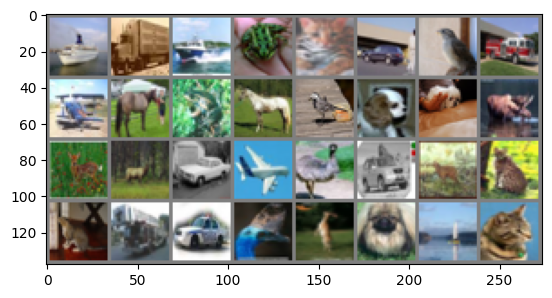

Etiquetas: 
 horse
   dog
 airplane
   dog
   cat
  deer
 automobile
  ship
 truck
 horse
 automobile
 airplane
   cat
   dog
  ship
  ship
  deer
  ship
 automobile
  deer
 automobile
  frog
   dog
 horse
 horse
 horse
  deer
 automobile
  deer
  ship
  deer
  frog



In [68]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

corrupt_prob = 0.8 # Probabilidad de corrupción
batch_size = 32  # Tamaño del lote

# Transformaciones
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Crear el conjunto de datos CIFAR10Corrupted
trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Obtener un lote de imágenes
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostrar las imágenes
imshow(torchvision.utils.make_grid(images))
name_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Etiquetas: \n', ' '.join('%5s\n' % name_labels[labels[j]] for j in range(batch_size)))


In [69]:
"""
Esta función devuelve los dataloaders de CIFAR10 con las imágenes corrompidas con una probabilidad dada.
Los dataloaders son los mismos que los de CIFAR10, pero con las etiquetas corrompidas, estos se encargan de cargar los datos en lotes.
"""
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=32):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    print("Trainset: ", trainset)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



# Inception Neural Network

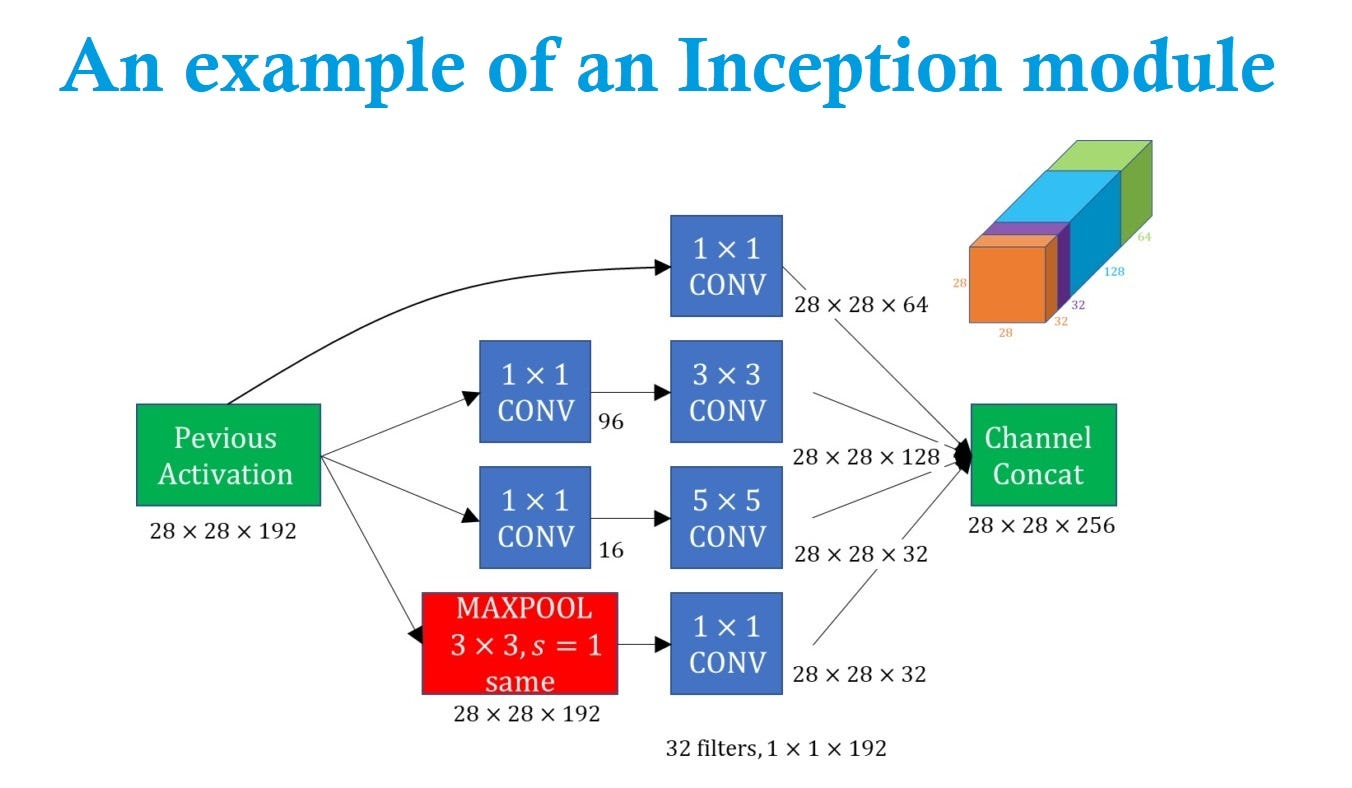

- `in_channels`: Número de canales en la entrada (por ejemplo, 3 para imágenes RGB).
- `out_channels`: Número de canales de salida que produce la convolución.
- `kernel_size`: Tamaño del filtro (por ejemplo, 5 para una convolución 5x5).
- `stride`: Paso de la convolución, es decir, el número de píxeles que se desplaza el filtro en cada paso.
- `padding`: Cantidad de padding (relleno) añadido a los bordes de la entrada.

In [70]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
"""
La clase InceptionModule en PyTorch define un módulo que simula el funcionamiento de un módulo de tipo Inception, que es una arquitectura popular en redes neuronales
convolucionales utilizada en modelos como GoogLeNet. Esta arquitectura se basa en la idea de aplicar convoluciones de diferentes tamaños en paralelo y luego
concatenar los resultados.
"""
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

# Functions to run the randomization test

In [71]:
def run_train_single_epoch(train_loader, model, device, criterion, optimizer):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0:
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(train_loader.sampler)
    epoch_acc = num_correct/len(train_loader.sampler)
    return epoch_loss, epoch_acc

In [72]:
def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(valid_loader.sampler)
    epoch_acc = num_correct/len(valid_loader.sampler)
    return epoch_loss, epoch_acc

In [73]:

"""
Next, we define the training loop. This function trains the model for a given number of epochs and 
returns the training and validation losses and accuracies.
"""
def training_loop(model, num_epochs, train_loader, valid_loader, device, \
                criterion, optimizer, model_name):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(train_loader, model, device, criterion, optimizer)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
        # else:
        #     print("Early stopping.")
        #     break
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs


In [74]:

def run_testing(test_loader, model, device):
    model.eval()
    gt_all, preds_all = [], []
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        gt_all.extend(labels.tolist())
        preds_all.extend(preds.tolist())
    return gt_all, preds_all

# Function to plot results

In [75]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

Declare a dictionary where is the probability of each class be changed, for example, if we want to change the probability of the class 0 be changed we can use the following dictionary:

In [76]:
final_dict = dict()

# Tests varying the corruption probability

## Test for corruption level 0.0: True labels

In [77]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [78]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [79]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 100, train_loader, test_loader,
                                        device, criterion, optimizer, "InceptionNet_corr_0")

Batch 0 Loss: 2.4626851081848145
Batch 200 Loss: 1.2514832019805908
Batch 400 Loss: 1.4705277681350708
Batch 600 Loss: 1.0676802396774292
Batch 800 Loss: 1.1214412450790405
Batch 1000 Loss: 1.314821720123291
Batch 1200 Loss: 1.0546799898147583
Batch 1400 Loss: 0.804111659526825
[Epoch 0] Train Loss: 1.250805615940094 Vaidation Loss: 0.9329495464324952 Train Acc: 0.57212 Validation Acc: 0.6937
Batch 0 Loss: 0.9268289804458618
Batch 200 Loss: 0.9001811146736145
Batch 400 Loss: 0.5888609886169434
Batch 600 Loss: 0.48856374621391296
Batch 800 Loss: 0.5020286440849304
Batch 1000 Loss: 0.6987833380699158
Batch 1200 Loss: 0.7811967134475708
Batch 1400 Loss: 0.5705316066741943
[Epoch 1] Train Loss: 0.7402140407848358 Vaidation Loss: 0.7333555655956269 Train Acc: 0.74816 Validation Acc: 0.7556
Batch 0 Loss: 0.32450443506240845
Batch 200 Loss: 0.4700082540512085
Batch 400 Loss: 0.8535007834434509
Batch 600 Loss: 0.7487118244171143
Batch 800 Loss: 0.7336722016334534
Batch 1000 Loss: 0.39274954795

### Graphs results for corruption level 0.0

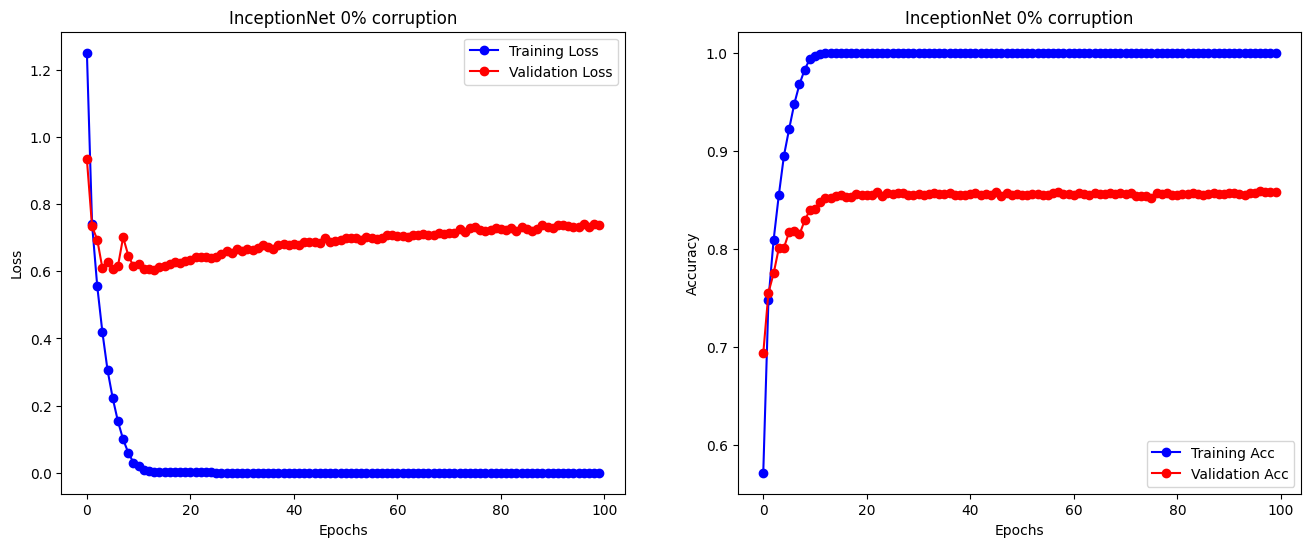

In [80]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 0% corruption")

### Confusion matrix for corruption level 0.0

In [81]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_0.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.8588
Confusion Matrix:
 [[876  11  16  15  15   3   7   8  28  21]
 [  4 936   0   5   2   1   4   1  10  37]
 [ 31   5 776  44  48  42  28  18   4   4]
 [ 19   4  44 712  42 107  35  26   9   2]
 [  5   0  37  26 865  19  17  23   6   2]
 [  7   2  15  99  33 795  19  29   1   0]
 [  4   0  20  30  19  15 898   7   4   3]
 [  9   1  10  21  26  19   4 902   0   8]
 [ 32  13   7   6   3   1   2   2 922  12]
 [ 18  42   4   3   2   3   2   7  13 906]]


In [82]:
final_dict[0] = {}
final_dict[0]["train_losses"] = train_losses
final_dict[0]["valid_losses"] = valid_losses
final_dict[0]["train_accs"] = train_accs
final_dict[0]["validation_accs"] = validation_accs
final_dict[0]["best_test_acc"] = accuracy_score(testy, pred)


# Test for corruption level 0.2

Load the CIFAR10 dataset and corrupt the labels with a probability of 0.2.

In [83]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.2)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
cuda:0


Create an instance of the InceptionNet model and train it using the CIFAR10 dataset with the corrupted labels.

In [84]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [85]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 100, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_20")

Batch 0 Loss: 2.336683511734009
Batch 200 Loss: 2.2026169300079346
Batch 400 Loss: 1.6009715795516968
Batch 600 Loss: 1.8431308269500732
Batch 800 Loss: 1.5638561248779297
Batch 1000 Loss: 1.9490817785263062
Batch 1200 Loss: 1.491460919380188
Batch 1400 Loss: 1.8963115215301514
[Epoch 0] Train Loss: 1.7998733151626587 Vaidation Loss: 1.5470356447219848 Train Acc: 0.42766 Validation Acc: 0.5432
Batch 0 Loss: 1.3231807947158813
Batch 200 Loss: 1.244034767150879
Batch 400 Loss: 1.0700702667236328
Batch 600 Loss: 1.3872692584991455
Batch 800 Loss: 1.4772504568099976
Batch 1000 Loss: 1.2263853549957275
Batch 1200 Loss: 1.3632673025131226
Batch 1400 Loss: 2.1681172847747803
[Epoch 1] Train Loss: 1.485310217666626 Vaidation Loss: 1.5090823650360108 Train Acc: 0.56276 Validation Acc: 0.5638
Batch 0 Loss: 1.195909023284912
Batch 200 Loss: 1.7643932104110718
Batch 400 Loss: 1.2524467706680298
Batch 600 Loss: 1.3844174146652222
Batch 800 Loss: 1.6033235788345337
Batch 1000 Loss: 1.563168168067932

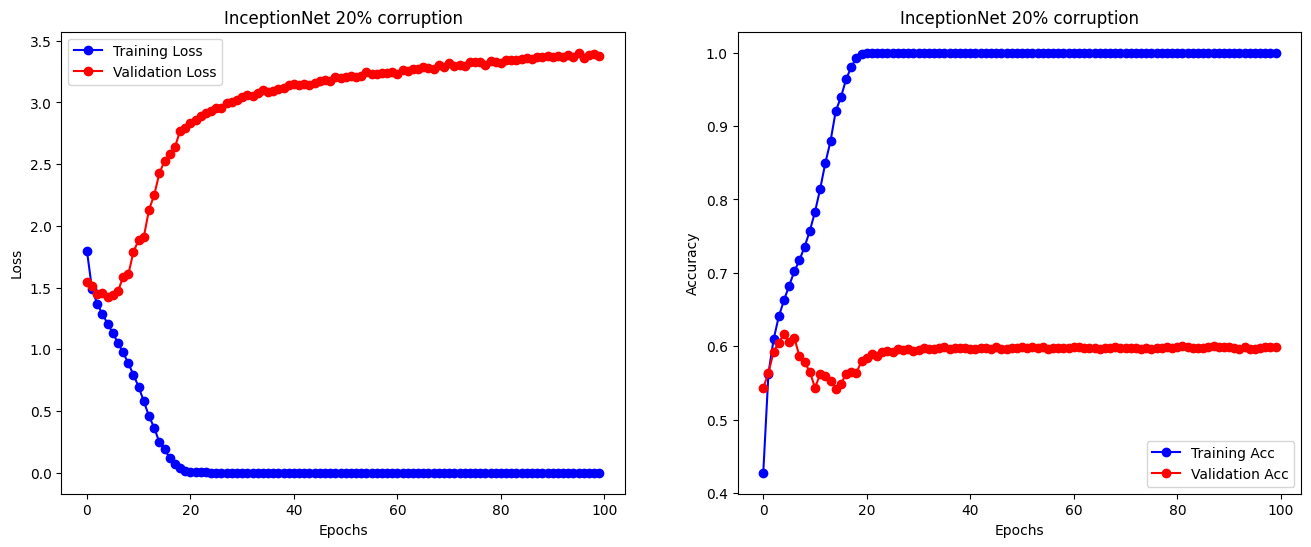

In [86]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 20% corruption")

In [87]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_20.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.6164
Confusion Matrix:
 [[612  28  60  54  25  39  29  55  68  26]
 [ 36 708  21  23  23  34  37  45  24  49]
 [ 57  34 500  64  64  63  71  98  18  20]
 [ 33  30  60 485  50 180  60  81  25  29]
 [ 34  25  57  62 540  57  56 114  18  23]
 [ 24  23  36  86  49 608  38 102  11  13]
 [ 23  24  55  59  41  38 686  53  26  13]
 [ 24  29  24  44  53  49  20 696  20  12]
 [ 62  46  37  37  11  34  26  45 669  30]
 [ 50  71  20  38  18  36  28  61  38 660]]


In [88]:
final_dict[20] = {}
final_dict[20]["train_losses"] = train_losses
final_dict[20]["valid_losses"] = valid_losses
final_dict[20]["train_accs"] = train_accs
final_dict[20]["validation_accs"] = validation_accs
final_dict[20]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 0.4

In [89]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [90]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [91]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 100, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_40")

Batch 0 Loss: 2.44565749168396
Batch 200 Loss: 3.1060545444488525
Batch 400 Loss: 2.445997476577759
Batch 600 Loss: 2.449573040008545
Batch 800 Loss: 2.017138957977295
Batch 1000 Loss: 1.7324857711791992
Batch 1200 Loss: 1.994118094444275
Batch 1400 Loss: 1.8024654388427734
[Epoch 0] Train Loss: 2.155691920890808 Vaidation Loss: 1.966873229598999 Train Acc: 0.29682 Validation Acc: 0.3766
Batch 0 Loss: 1.6703972816467285
Batch 200 Loss: 2.1164233684539795
Batch 400 Loss: 2.0151896476745605
Batch 600 Loss: 2.0158755779266357
Batch 800 Loss: 2.1523311138153076
Batch 1000 Loss: 2.0598347187042236
Batch 1200 Loss: 1.8337005376815796
Batch 1400 Loss: 1.8174571990966797
[Epoch 1] Train Loss: 1.8969566635513306 Vaidation Loss: 1.8845769477844239 Train Acc: 0.4097 Validation Acc: 0.4259
Batch 0 Loss: 1.747945785522461
Batch 200 Loss: 1.5989429950714111
Batch 400 Loss: 1.4161133766174316
Batch 600 Loss: 2.020982265472412
Batch 800 Loss: 2.0491554737091064
Batch 1000 Loss: 1.7630250453948975
Batc

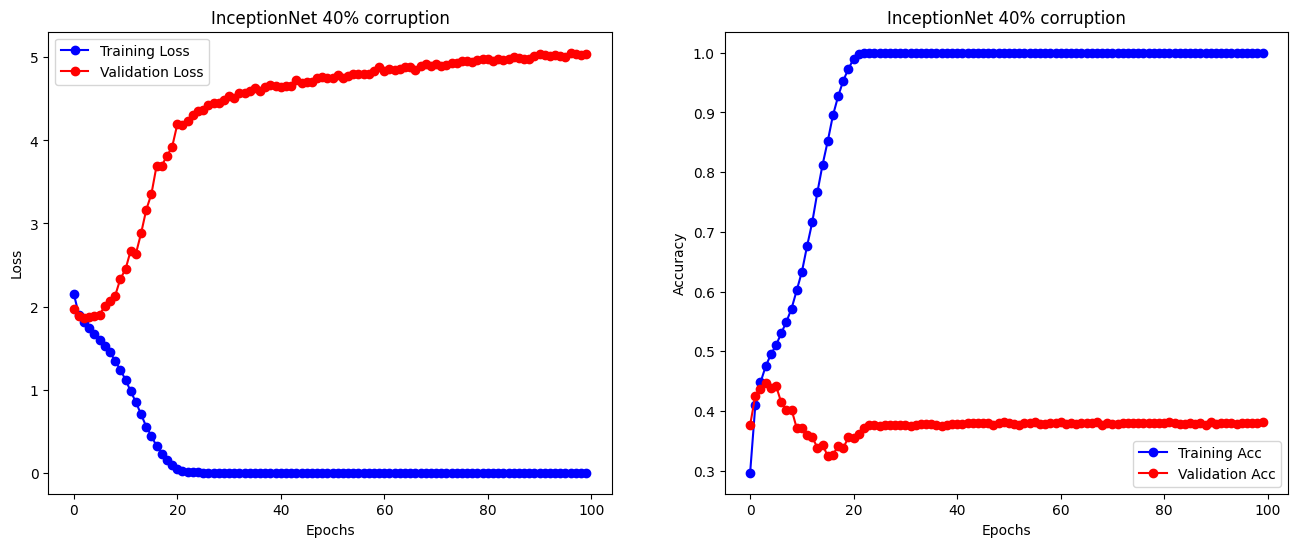

In [92]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 40% corruption")

In [93]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_40.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.4476
Confusion Matrix:
 [[527  39  59  39 112  33  44  19  75  73]
 [ 62 481  42  32  91  33  34  14  70 150]
 [ 93  41 342  55 192  73  61  27  50  60]
 [ 81  42  76 296 196 122  63  29  45  83]
 [ 75  32  43  37 570  52  60  32  41  49]
 [ 68  32  75  86 155 375  54  33  53  50]
 [ 45  26  50  59 151  65 487  24  50  55]
 [ 72  30  60  53 185  93  43 306  37 106]
 [106  44  28  34  76  31  39  34 512  67]
 [ 61  62  27  34  75  51  43  23  48 580]]


In [94]:
final_dict[40] = {}
final_dict[40]["train_losses"] = train_losses
final_dict[40]["valid_losses"] = valid_losses
final_dict[40]["train_accs"] = train_accs
final_dict[40]["validation_accs"] = validation_accs
final_dict[40]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 0.6

In [95]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.6)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [96]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [97]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 100, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_60")

Batch 0 Loss: 2.3474764823913574
Batch 200 Loss: 2.5419669151306152
Batch 400 Loss: 2.376084566116333
Batch 600 Loss: 2.1887965202331543
Batch 800 Loss: 2.288919687271118
Batch 1000 Loss: 2.2881648540496826
Batch 1200 Loss: 2.236236095428467
Batch 1400 Loss: 2.155851364135742
[Epoch 0] Train Loss: 2.2848229409790037 Vaidation Loss: 2.223492988586426 Train Acc: 0.20476 Validation Acc: 0.2347
Batch 0 Loss: 2.0880448818206787
Batch 200 Loss: 2.1085197925567627
Batch 400 Loss: 2.0456254482269287
Batch 600 Loss: 2.224055290222168
Batch 800 Loss: 2.1242165565490723
Batch 1000 Loss: 2.030200958251953
Batch 1200 Loss: 2.2932167053222656
Batch 1400 Loss: 2.281040668487549
[Epoch 1] Train Loss: 2.160165517883301 Vaidation Loss: 2.16389923286438 Train Acc: 0.26596 Validation Acc: 0.2716
Batch 0 Loss: 2.555919647216797
Batch 200 Loss: 2.25010347366333
Batch 400 Loss: 1.9368690252304077
Batch 600 Loss: 1.9563804864883423
Batch 800 Loss: 1.9216487407684326
Batch 1000 Loss: 2.453397274017334
Batch 12

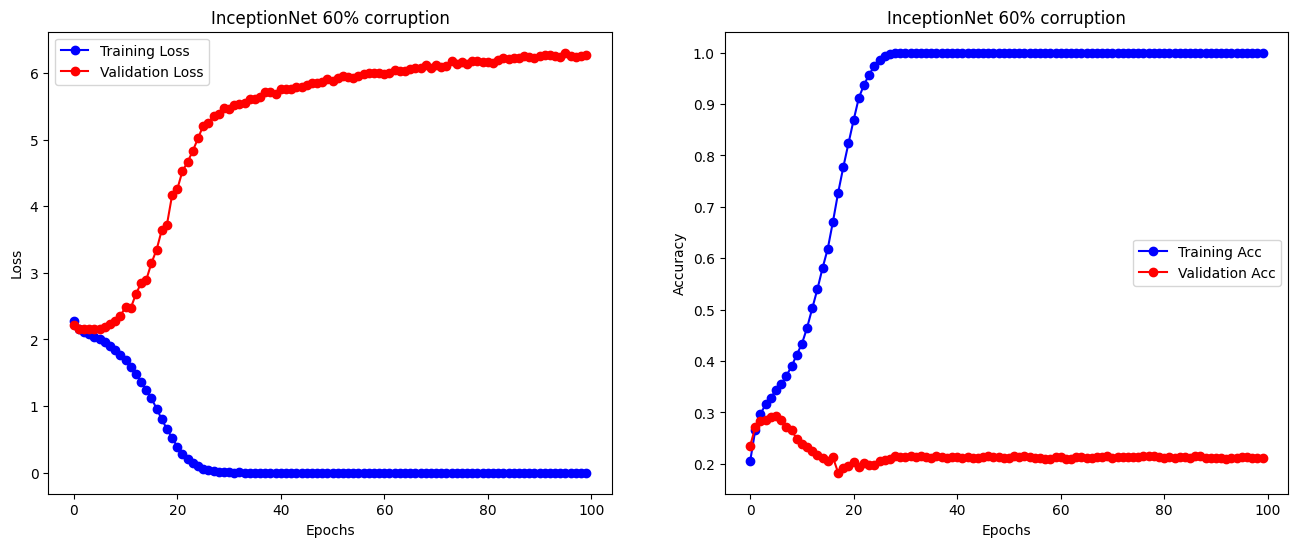

In [98]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 60% corruption")

In [99]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_60.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.2935
Confusion Matrix:
 [[288  59  59  39  96  50  60 124 184  68]
 [ 65 326  62  28 101  46  60 104 148  86]
 [ 79  50 227  40 138  50  58 137 140  67]
 [ 52  54  70 135 151  99  97 148 134  81]
 [ 57  46  65  45 333  58  64 133 119  59]
 [ 43  71  79  54 112 193  62 155 130  75]
 [ 61  61  80  43 121  43 307 116 126  54]
 [ 58  76  58  42 109  53  63 392 109  49]
 [ 65  68  41  30  75  46  54  92 439  70]
 [ 56  87  57  27 110  45  59 110 140 295]]


In [100]:
final_dict[60] = {}
final_dict[60]["train_losses"] = train_losses
final_dict[60]["valid_losses"] = valid_losses
final_dict[60]["train_accs"] = train_accs
final_dict[60]["validation_accs"] = validation_accs
final_dict[60]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 0.8

In [101]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.8)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
cuda:0


In [102]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [103]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 100, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_80")

Batch 0 Loss: 2.375370502471924
Batch 200 Loss: 2.5092689990997314
Batch 400 Loss: 2.6435325145721436
Batch 600 Loss: 2.2808713912963867
Batch 800 Loss: 2.3303675651550293
Batch 1000 Loss: 2.285565137863159
Batch 1200 Loss: 2.214914321899414
Batch 1400 Loss: 2.293464183807373
[Epoch 0] Train Loss: 2.3767018121337893 Vaidation Loss: 2.303210682296753 Train Acc: 0.12536 Validation Acc: 0.144
Batch 0 Loss: 2.364326238632202
Batch 200 Loss: 2.3105969429016113
Batch 400 Loss: 2.3442883491516113
Batch 600 Loss: 2.33250093460083
Batch 800 Loss: 2.230815887451172
Batch 1000 Loss: 2.1394195556640625
Batch 1200 Loss: 2.3042755126953125
Batch 1400 Loss: 2.238553762435913
[Epoch 1] Train Loss: 2.286845910720825 Vaidation Loss: 2.292220058822632 Train Acc: 0.15332 Validation Acc: 0.1503
Batch 0 Loss: 2.243983507156372
Batch 200 Loss: 2.1310596466064453
Batch 400 Loss: 2.1965491771698
Batch 600 Loss: 2.2611489295959473
Batch 800 Loss: 2.285601854324341
Batch 1000 Loss: 2.313291549682617
Batch 1200 L

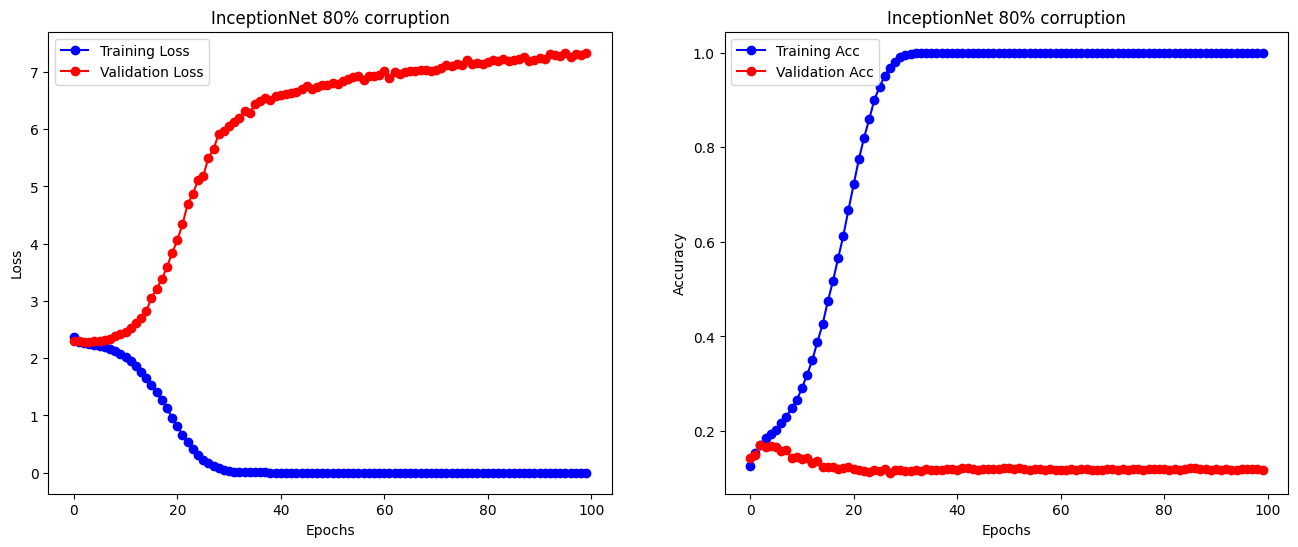

In [104]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 80% corruption")

In [105]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_80.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1707
Confusion Matrix:
 [[137 164 172  42   1 113  84  96 130  72]
 [ 65 312 145  44   1  92  81  94 103  92]
 [ 78 162 239  57   2 108  85 109  92  55]
 [ 74 178 172  78   3 144 108 113  93  57]
 [ 62 146 246  54   3 107  83 114  89  50]
 [ 72 164 177  52   4 168  82 113  86  63]
 [ 71 167 173  42   6  95 202  89  99  71]
 [ 66 151 165  50   3 107  79 204 101  72]
 [ 84 176 146  49   1  82  82  86 213  68]
 [ 91 204 156  43   1  85  64 112 111 151]]


In [106]:
final_dict[80] = {}
final_dict[80]["train_losses"] = train_losses
final_dict[80]["valid_losses"] = valid_losses
final_dict[80]["train_accs"] = train_accs
final_dict[80]["validation_accs"] = validation_accs
final_dict[80]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 1: Random labels

In [107]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(1.0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [108]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [109]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 100, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_100")

Batch 0 Loss: 2.3360090255737305
Batch 200 Loss: 2.8217601776123047
Batch 400 Loss: 2.469731569290161
Batch 600 Loss: 2.316896677017212
Batch 800 Loss: 2.3877553939819336
Batch 1000 Loss: 2.3649234771728516
Batch 1200 Loss: 2.4274423122406006
Batch 1400 Loss: 2.2690460681915283
[Epoch 0] Train Loss: 2.430556290359497 Vaidation Loss: 2.349097986602783 Train Acc: 0.10194 Validation Acc: 0.0934
Batch 0 Loss: 2.345215320587158
Batch 200 Loss: 2.3931663036346436
Batch 400 Loss: 2.2721970081329346
Batch 600 Loss: 2.288205862045288
Batch 800 Loss: 2.2988994121551514
Batch 1000 Loss: 2.269681692123413
Batch 1200 Loss: 2.2341885566711426
Batch 1400 Loss: 2.3677051067352295
[Epoch 1] Train Loss: 2.318078878631592 Vaidation Loss: 2.3216007205963134 Train Acc: 0.10524 Validation Acc: 0.0982
Batch 0 Loss: 2.270660638809204
Batch 200 Loss: 2.3070333003997803
Batch 400 Loss: 2.2523000240325928
Batch 600 Loss: 2.3008203506469727
Batch 800 Loss: 2.2905757427215576
Batch 1000 Loss: 2.2588300704956055
Ba

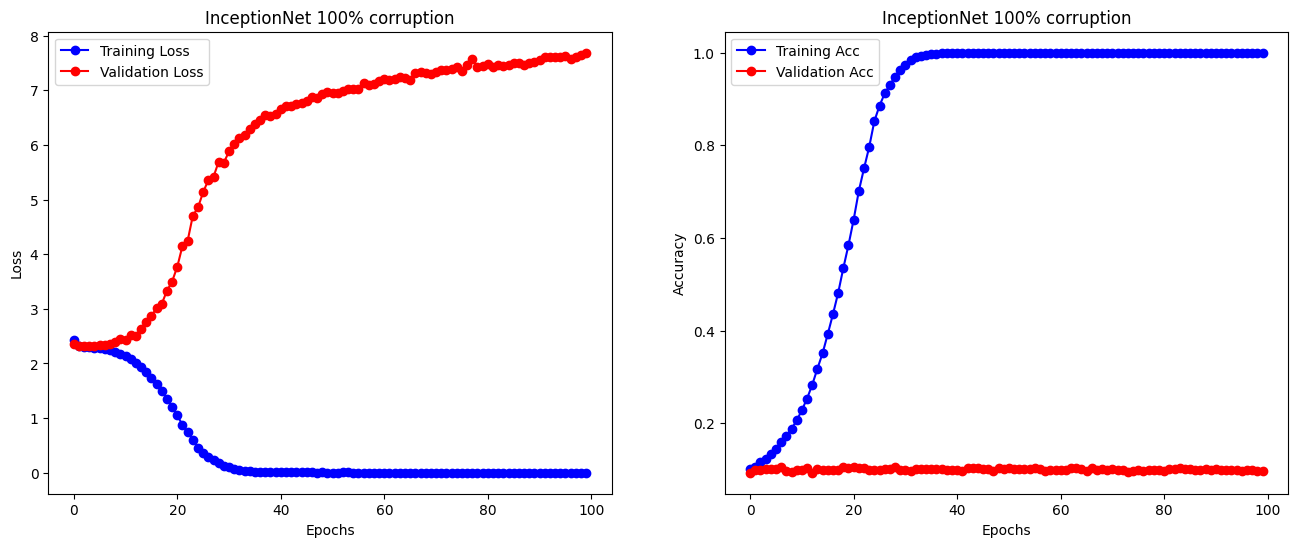

In [110]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 100% corruption")

In [111]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_100.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1064
Confusion Matrix:
 [[ 81 116 107 115 117 112 138  57  95  76]
 [105 145  95 121 137  85 150  55  74  73]
 [ 69 136 109 101 113 111 146  53  84  69]
 [ 74 140 122 124 136  89 114  61  84  68]
 [ 68 116 101 118 128  92 122  61  69  70]
 [ 77 128 105 114 120 115 134  76  63  85]
 [ 76 116 107 109 124 102 148  57  77  81]
 [ 75 114 110 100 135  99 137  64  82  77]
 [ 63 145 107 102 119  99 130  54  80  74]
 [ 76 123 114 130 113 112 133  62  85  70]]


In [112]:
final_dict[100] = {}
final_dict[100]["train_losses"] = train_losses
final_dict[100]["valid_losses"] = valid_losses
final_dict[100]["train_accs"] = train_accs
final_dict[100]["validation_accs"] = validation_accs
final_dict[100]["best_test_acc"]  = accuracy_score(testy, pred)


# Save the results

In [113]:
with open('final.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [114]:
!curl bashupload.com -T final.pickle



Uploaded 1 file, 21 929 bytes

wget http://bashupload.com/gkMv2/final.pickle




In [115]:
!zip inception.zip *.*
!curl bashupload.com -T inception.zip

updating: final.pickle (deflated 39%)
updating: InceptionNet_corr_0.pth (deflated 8%)
updating: InceptionNet_corr_100.pth (deflated 8%)
updating: InceptionNet_corr_20.pth (deflated 8%)
updating: InceptionNet_corr_40.pth (deflated 8%)
updating: InceptionNet_corr_60.pth (deflated 8%)
updating: InceptionNet_corr_80.pth (deflated 8%)
updating: Label_Corruption_Analysis.ipynb (deflated 28%)
updating: Label_Corruption_Inception.ipynb (deflated 28%)
updating: Label_Corruption_MLP.ipynb (deflated 40%)
updating: Label_Corruption_Wide_ResNet.ipynb (deflated 40%)
  adding: results_inception.ipynb (deflated 32%)


Uploaded 1 file, 42 036 811 bytes

wget http://bashupload.com/iDCa6/inception.zip


